In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [2]:
# Variabili globali

path = 'pala_10/24-05-2023 4 rounds/'

In [3]:
allacqui_temp = []
allacqui_input = []

# Andiamo a prendere tutti i path dei vari file
path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


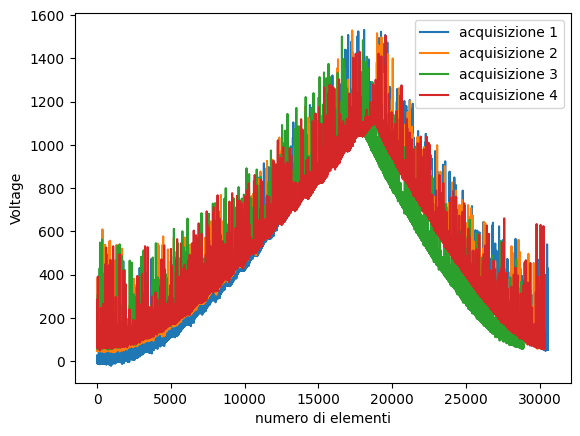

In [4]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("input" in a):
        allacqui_input.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui_temp.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))

allacqui = []
for a,b in zip(allacqui_temp,range(len(allacqui_temp))):
    if(b % 3 ==0):
        allacqui.append([])
        a['Voltage'] = (10 - a['Voltage'])*500
        plt.plot(a['Voltage'],label='acquisizione '+str(int((b/3)+1)))
        plt.ylabel('Voltage')
        plt.xlabel('numero di elementi')
    allacqui[-1].append(a)
plt.legend()



# Filtri per intervallo di input e output

In [5]:
all_acqui_new = []

for a in range(len(allacqui_input)):
    all_acqui_new.append([])
    for b in range(3):
        all_acqui_new[-1].append(
            allacqui[a][b][(allacqui[a][b]['time'] > allacqui_input[a]['time'][allacqui_input[a]['pwm_percent'] == 37].values[0])
                           & (allacqui[a][b]['time'] < allacqui_input[a]['time'][allacqui_input[a]['pwm_percent'] == 77].values[0])]
        )

pwm_max = 2000
pwm_min = 1000
allacqui = all_acqui_new

In [7]:
for a in range(len(allacqui)):
    for b in range(len(allacqui[0])):
        allacqui[a][b].reset_index(drop=True,inplace=True)

In [9]:
# Check delle dimensioni
for a in range(len(allacqui[0])):
    print(allacqui[0][a].shape)

(7278, 2)
(6927, 2)
(6946, 2)


# Filtro dei rumori sulle acquisizioni

In [10]:
#mediana mobile
allacqui[0][0] = allacqui[0][0].rolling(30,min_periods = 1,center=False).median()
allacqui[1][0] = allacqui[1][0].rolling(30,min_periods = 1,center=False).median()
allacqui[2][0] = allacqui[2][0].rolling(30,min_periods = 1,center=False).median()
allacqui[3][0] = allacqui[3][0].rolling(30,min_periods = 1,center=False).median()

In [13]:
# Andiamo a lavorare sui dati di national instrument

data_matrix = allacqui[0][2]['volts']
grid_points = allacqui[0][2]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)

c:\Users\Leo\.conda\envs\manu2\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


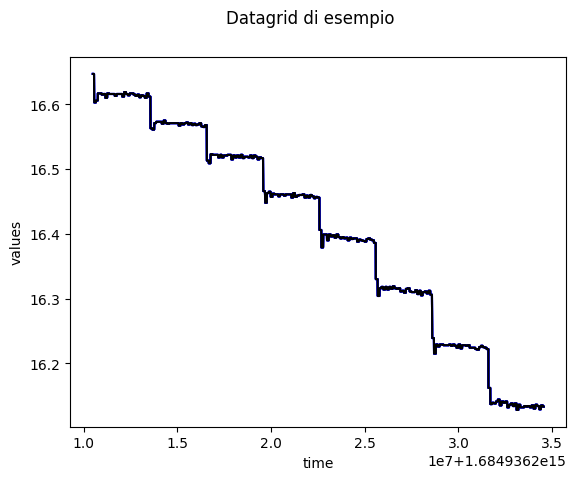

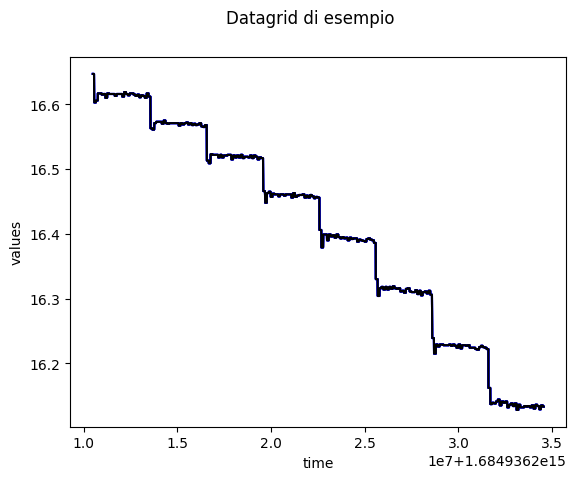

In [14]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

# Mappatura del dataset input

In [15]:
import numpy as np
# questo modo e' piu' veloce rispetto a un for nomale di python
def makepwm(d):
    off_setList = len([d-x for x in b['time'] if (d - x > 0)])
    if(off_setList == 0):
       return 0
    else:
      return b['pwm_percent'][off_setList-1]
makepwmElem = np.vectorize(makepwm)

In [16]:
all_PWMoutput = []
#Applicazione della mappatura
for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        all_PWMoutput[-1].append([])
        all_PWMoutput[-1][-1] = pwm_min + ((makepwmElem(timestamp['time']) * (pwm_max-pwm_min))/100)

In [17]:
# Creazione del datagrid per una migliore visualizzazione e della regressione.

all_data_grid = []
datasetTitles = ['National Instrument','RPM','Battery']
for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    all_data_grid.append([])
    for a,b,i in zip(acqui,pwmoutput,range(len(acqui))):
        print(a.columns.values)        
        data_matrix = np.stack((np.array(a[a.columns.values[1]]), np.array(b)))
        grid_points = a[a.columns.values[0]]

        all_data_grid[-1].append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name=datasetTitles[i],
        argument_names=(a.columns.values[0],),
        
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

['time' 'Voltage']
['time' 'rpm']
['time' 'volts']
['time' 'Voltage']
['time' 'rpm']
['time' 'volts']
['time' 'Voltage']
['time' 'rpm']
['time' 'volts']
['time' 'Voltage']
['time' 'rpm']
['time' 'volts']


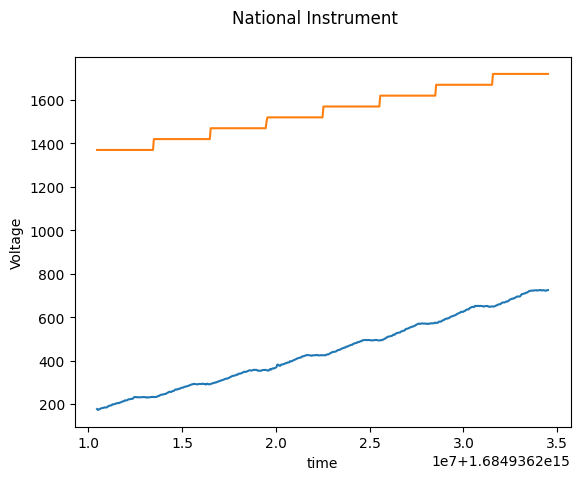

In [18]:
all_data_grid[0][0].plot()
print()

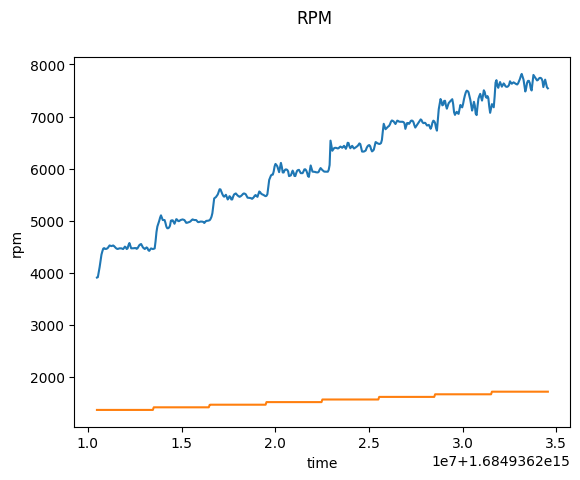

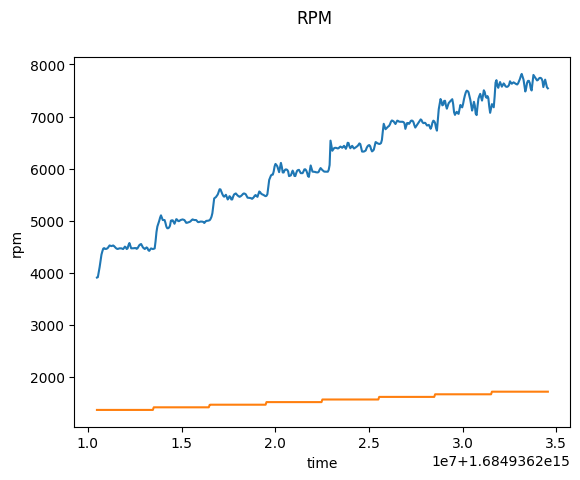

In [19]:
all_data_grid[0][1].plot()

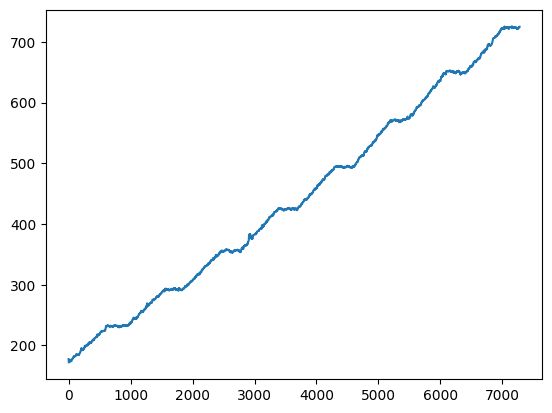

In [20]:
plt.plot(all_data_grid[0][0].data_matrix[0])


# Regressione polinomiale del National Instrument

In [21]:
#Regressione polimoniale del National Instrument

pol_maxGrade = 4
fit_result = []
for acquisizione in all_data_grid:
    fit_result.append([])
    for dataset in acquisizione:

        fit_result[-1].append([])
        for i in range(pol_maxGrade):
            fit_result[-1][-1].append(polyfit(dataset.data_matrix[1][:,0],dataset.data_matrix[0],deg=i+1))


# Grafico del risultato

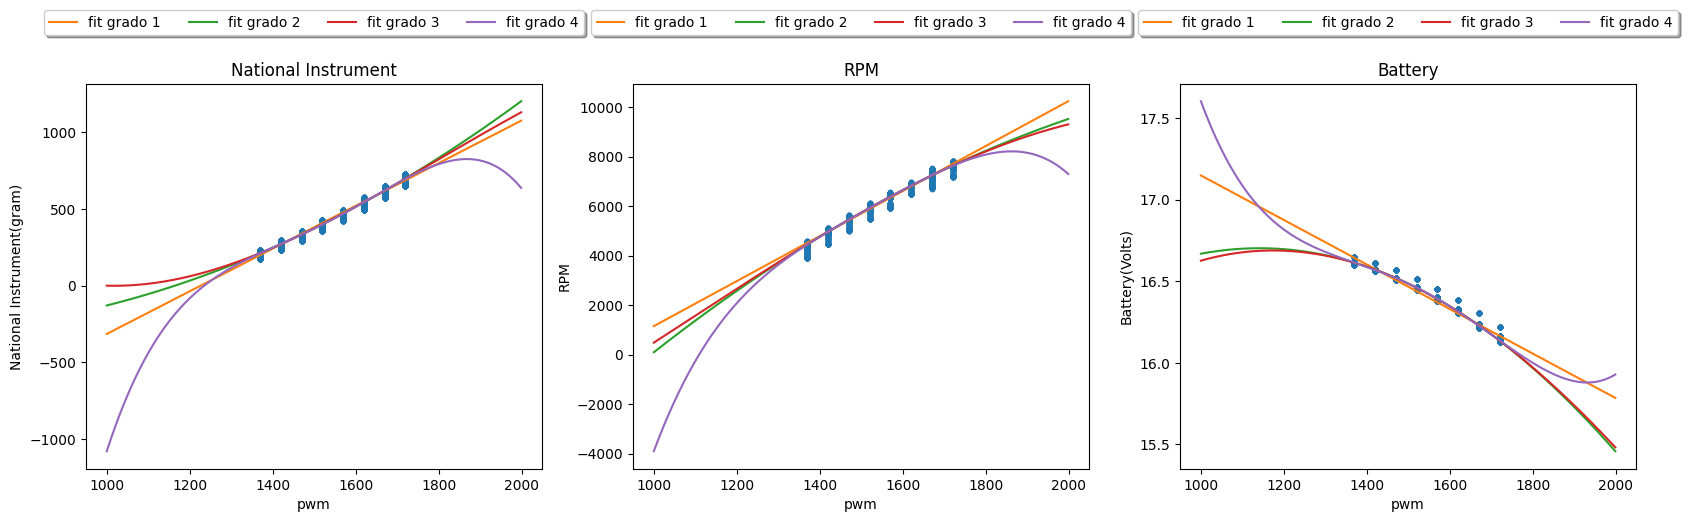

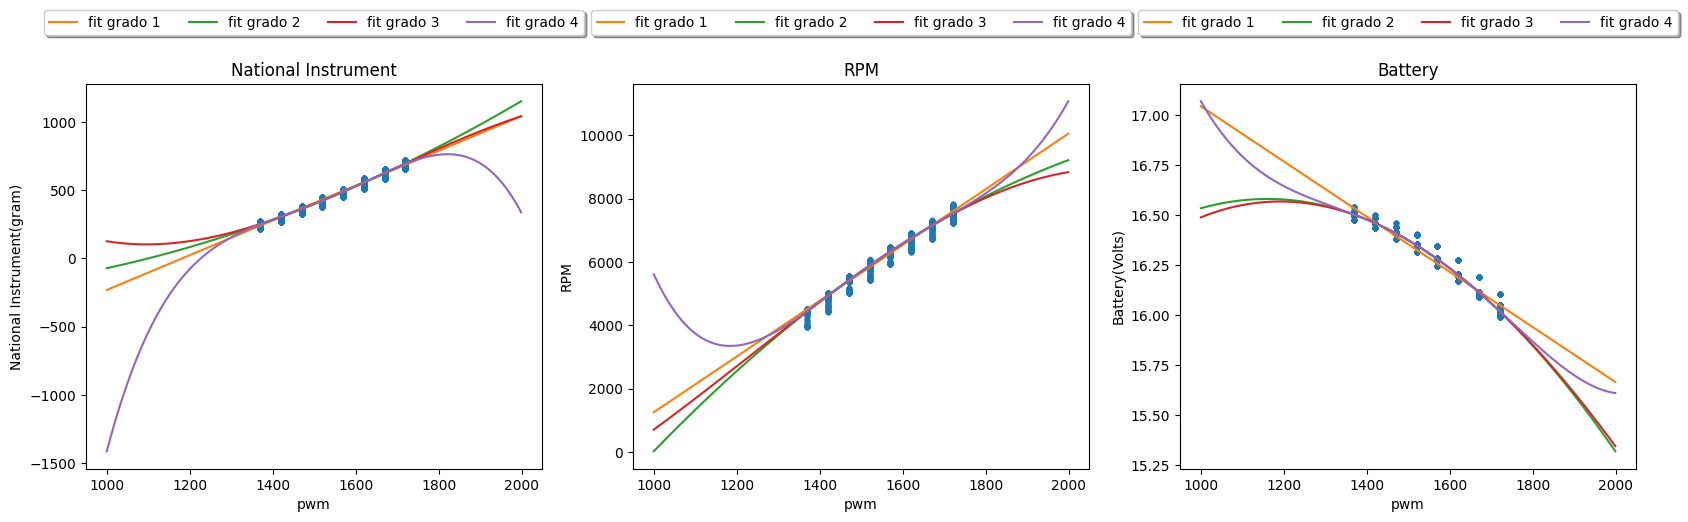

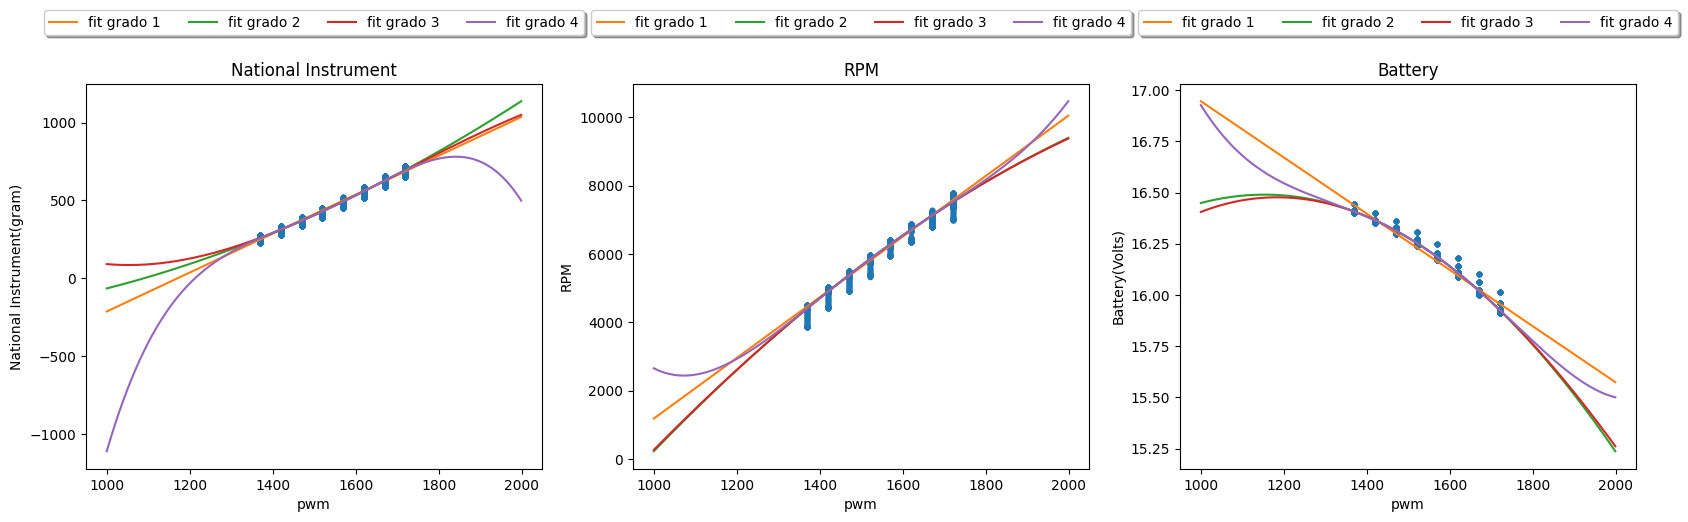

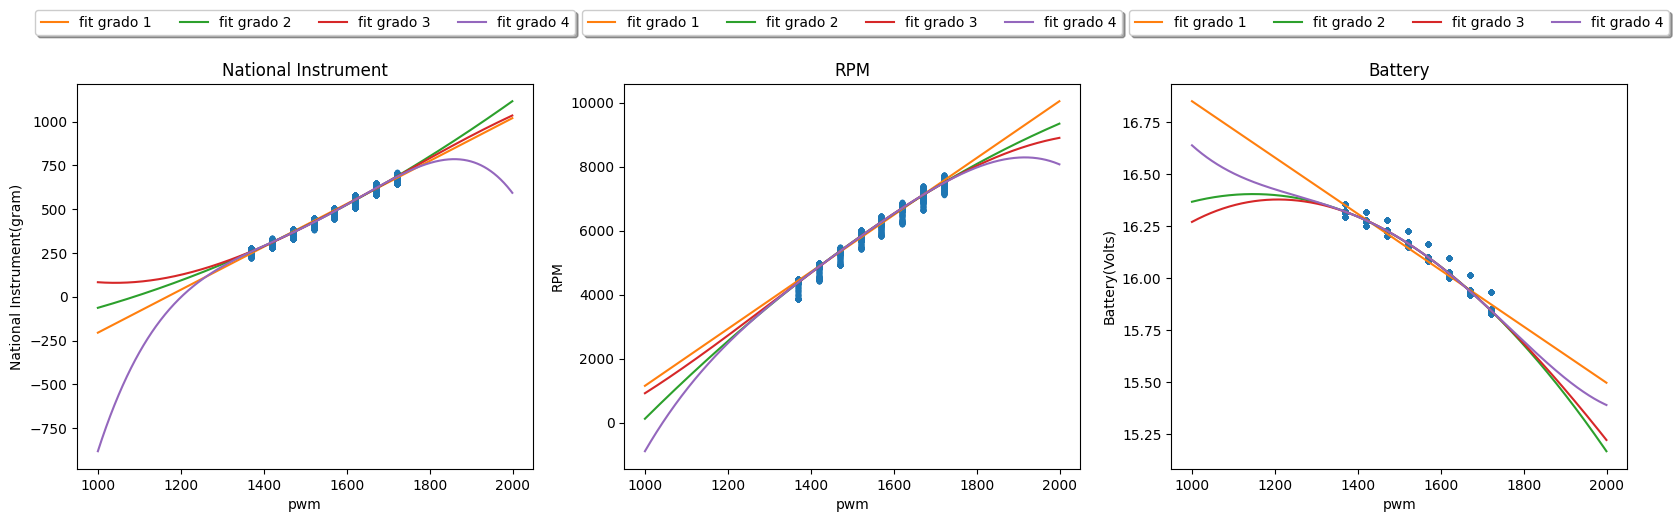

In [22]:
datasetYLabel = ['National Instrument(gram)','RPM','Battery(Volts)']
for acquisizione,fit_set in zip(all_data_grid,fit_result):
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    fig.set_size_inches(h=5,w=20)
    
    linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
    
    for dataset,dataset_fit,index in zip(acquisizione,fit_set,range(len(acquisizione))):
        axs[index].plot(dataset.data_matrix[1][:,0],dataset.data_matrix[0],'.')
        axs[index].set_xlabel('pwm')
        axs[index].set_ylabel(datasetYLabel[index])
        for fit,indice in zip(dataset_fit,range(pol_maxGrade)):
            plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
            for i in range(len(fit)):
                plotRes += np.multiply(fit[i],np.power(linex,i))
            axs[index].plot(linex, plotRes,'-',label='fit grado '+str(indice+1))
        axs[index].set_title(datasetTitles[index])
        axs[index].legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=4, fancybox=True, shadow=True)

# Calcolo dell'errore quadratico medio

In [23]:
# Calcolo dell'errore quadratico medio per un singolo grafico
grafico = 0
y_pred = all_data_grid[grafico][0].data_matrix[0]
for fit,g in zip(fit_result[grafico][0],range(len(fit_result[1][0]))):
    y_true = 0
    for i in range(len(fit)):
        y_true += fit[i]*all_data_grid[grafico][0].data_matrix[1][:,0]**i
    print('grado' + str(g+1))
    print(mean_squared_error(y_true, y_pred[:,0]))

grado1
627.3957205967
grado2
570.861117735754
grado3
569.9906745594342
grado4
568.329131969831


In [25]:
# Andiamo a calcolare le metriche per ogni grafico

result = []

matrici = [np.zeros([int(3),int(4)]),np.zeros([int(3),int(4)]),np.zeros([int(3),int(4)]),np.zeros([int(3),int(4)])]

for sing_acqui in range(len(all_data_grid)):
    for a in range(len(all_data_grid[sing_acqui])):
        y_pred = all_data_grid[sing_acqui][a].data_matrix[0]
        for fit,g in zip(fit_result[sing_acqui][a],range(len(fit_result[1][0]))):
            y_true = 0
            for i in range(len(fit)):
                y_true += fit[i]*all_data_grid[sing_acqui][a].data_matrix[1][:,0]**i
            
            matrici[sing_acqui][a,g] = mean_squared_error(y_true, y_pred[:,0])

fine acquisizione
fine acquisizione
fine acquisizione
fine acquisizione


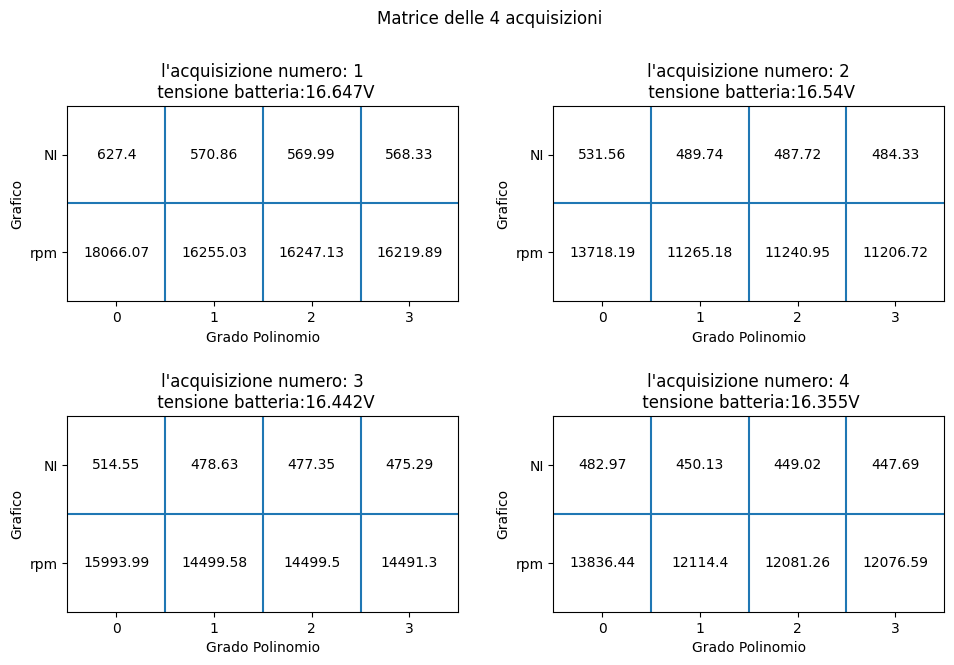

In [26]:
#Stampa del risultato 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('Matrice delle 4 acquisizioni')
fig.tight_layout(pad=1.3)
label = ['NI','rpm']
fig.set_size_inches(10,7)
for m in range(len(matrici)):
    matrici[m] = matrici[m][0:2]

for a,axs in zip(range(len(matrici)),[ax1, ax2, ax3, ax4]):
    

    image = axs.imshow(np.full((2, 4, 3),
                        255, dtype = np.uint16))

    axs.set_xlabel("Grado Polinomio")
    axs.set_ylabel("Grafico")
    axs.set_title("l'acquisizione numero: {}".format(a+1, 's')+"\n tensione batteria:"+str(allacqui[a][2].iloc[0]['volts'])+"V")
    axs.xaxis.set_ticks(np.arange(0, 4, 1))
    axs.yaxis.set_ticks(np.arange(0, 2, 1),label)
    axs.axhline(0.5)

    axs.axvline(0.5)
    axs.axvline(1.5)
    axs.axvline(2.5)

    

    for i in range(0,matrici[a].shape[0]):
        for j in range(0,matrici[a].shape[1]):
            c = np.round(matrici[a][i,j],decimals=2)
            axs.text(j, i, str(c), va='center', ha='center')

    

